# Taller Fourier 2021 - Clasificación de cargas de electrodomésticos


## Práctica 5 - Integración de la solución

### Objetivos:
En esta práctica se busca integrar los distintos módulos desarrollados a lo largo del taller.


### Actividades

1. Adquisición de señales para el armado de la base de datos EDM-IIE  
Dado un electrodoméstico conectado a la caja se adquieren las señales V e I.
Los datos adquiridos se guardan en un archivo .csv y la metadata en otro archivo. 
Con los datos recolectados en las distintas casas se construirá la base EDM-IIE.  

2. Entrenamiento de un clasificador con la base PLAID
Con la experiencia de la práctica 4 se entrenará un clasificador con la base PLAID  

3. Clasificación de los electrodomésticos de la base EDM-IIE con el clasificador entrenado con PLAID  

4. Entrenamiento de un clasificador con la base EDM-IIE  
En forma similar a lo realizado en la práctica 4, se entrenará un clasificador con la base EDM-IIE y se evaluará su desempeño

5. Adquisición y clasificación  
Dado un electrodoméstico conectado a la caja se adquieren las señales V e I, se extraen las características y se clasifica

### Materiales

Se usa una base de referencia de señales V-I correspondiente a once tipos distintos de electrodomésticos ('Air Conditioner', 'Compact Fluorescent Lamp', 'Fan', 'Fridge', 'Hairdryer', 'Heater', 'Incandescent Light Bulb', 'Laptop', 'Microwave', 'Vacuum', 'Washing Machine'). La base está disponible en http://www.plaidplug.com/, [1].

Las señales, de 2 a 5 segundos de duración, están en archivos ".csv" donde la primera columna es la intensidad y la segunda columna es el voltaje.  
La frecuencia de línea de las señales es $F_l=60Hz$.  
La frecuencia de muestreo de las señales es $F_s=30kHz$.

[1] Gao, Jingkun, et al. "Plaid: a public dataset of high-resoultion electrical appliance measurements for load identification research: demo abstract." proceedings of the 1st ACM Conference on Embedded Systems for Energy-Efficient Buildings. ACM, 2014.


### Datos

La base de datos PLAID se baja de  http://www.plaidplug.com/.   

El archivo "meta1_simple.csv" en la carpeta "data" tiene tres columnas con la información sobre las señales de los electrodomésticos.   
Columnas:  
* identificador del electrodoméstico
* código del tipo del electrodoméstico
* identificador de la casa donde se registró la señal

Los tipos de electrodomésticos son  [código, nombre]:  
* 0: 'Air Conditioner',
* 1: 'Compact Fluorescent Lamp',
* 2: 'Fan',
* 3: 'Fridge',
* 4: 'Hairdryer',
* 5: 'Heater',
* 6: 'Incandescent Light Bulb',
* 7: 'Laptop',
* 8: 'Microwave',
* 9: 'Vacuum',
* 10: 'Washing Machine'

Por ejemplo, las señales I,V en el archivo '10.csv' corresponde al electrodoméstico con id=10, tipo=8 (Microwave) y de la casa=1.

### Uso de funciones de las prácticas 1, 2 y 4.

En esta práctica usaremos las funciones creadas en las prácticas 1, 2 y 4.  
Para eso se copiarán las funciones a archivos **funciones_practica_1.py**, **funciones_practica_2.py** y **funciones_practica_4.py** dentro del directorio **funciones**.  


Para poder usar las funciones se importarán con:  
**from funciones.funciones_practica_1 import * **  
**from funciones.funciones_practica_2 import * **  
**from funciones.funciones_practica_4 import * **  


### Trabajo a realizar

A lo largo del notebook encontrarán las siguientes palabras claves:

* \# COMPLETAR  -> indica que se requiere completar el código. 
  
  
* \# EXPERIMENTAR -> indica que la celda contiene código funcional que permite experimentar variando el tipo de electrodoméstico, parámetros de las funciones, etc. Es posible, si lo requiere la experimentación duplicar la celda y realizar los cambio que sean de interés en el código.
  
  
* \# DISCUTIR -> se espera una discusión de los experimentos realizados y/o de las preguntas formuladas
  
  
  
* \# RESPONDER -> se espera una respuesta a preguntas concretas

In [1]:
import os
import numpy as np
from scipy.fftpack import fft, fftshift, ifft
from scipy.signal import spectrogram
import matplotlib.pyplot as plt
from datetime import datetime
import time
import shutil
import pandas as pd


# autoreload. Los cambios en modulos externos como 'funciones_practica_1.py' se recargan automaticamente
%load_ext autoreload
%autoreload 2

# importar las funciones de la práctica 1
from funciones.funciones_practica_1 import *
from funciones.funciones_practica_2 import *
from funciones.funciones_practica_4 import * 

# importar funciones utiles
from funciones.util import plot_confusion_matrix

#estilo de las gráficas
plt.style.use('ggplot')


# graficas en línea  entre las celdas
#%matplotlib inline 
# graficas en línea  entre las celdas con pan/zoom
%matplotlib notebook
# graficas en ventanas externas
# %matplotlib



In [2]:
# importar funciones del módulo de aprendizaje sklearn
import sklearn
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.utils.multiclass import unique_labels

from sklearn.neighbors import KNeighborsClassifier as KNN
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import LogisticRegression
from sklearn import svm
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis as QDA 
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
from sklearn import tree
from sklearn.ensemble import RandomForestClassifier as RF, AdaBoostClassifier as ABC

## Parte 0 - Carga de los datos de la base PLAID y la base EDM-IIE

In [4]:
frecuencia_muestreo = 30000 #Frecuencia de muestreo en Hz
frecuencia_linea = 60    #Frecuencia de línea en Hz
muestras_por_ciclo = int(frecuencia_muestreo/frecuencia_linea)

nombres_electrodomesticos = ['Air Conditioner',
                         'Compact Fluorescent Lamp',
                         'Fan',
                         'Fridge',
                         'Hairdryer',
                         'Heater',
                         'Incandescent Light Bulb',
                         'Laptop',
                         'Microwave',
                         'Vacuum',
                         'Washing Machine',
                         'Other']

nombres_abreviados_electrodomesticos = ['AirC','CFL','Fan','Frid','Hair','Heat','ILB','Lapt','MWave','Vacc','Wash', 'Other']

# ubicación del directorio  de la base PLAID que contiene los ".csv"
PLAID_csv_directory = "C:/Users/carlos/Downloads/PLAID/CSV"

# archivo con la metadata de la base PLAID
archivo_metadata = './data/meta1_simple.csv'


# ubicación del directorio de la base EDM-IIE que contiene las señales en archivos ".csv"
EDM_IIE_csv_directory = './EDM_IIE/CSV'
# archivo con la metadata completa de la base EDM-IIE
EDM_IIE_archivo_full_metadata = './EDM_IIE/meta1_simple_iie_2019.csv'




### Testear las funciones de carga de meta-datos del base PLAID

In [90]:
# Testeos. Permite verificar que se cargan bien las funciones de la práctica 1

print('-------------------------------------------------------------') 
# Imprimir la cantidad de electrodomesticos en la base
print('Cantidad de electrodomésticos en la base:', get_cantidad_electrodomesticos() )

print('-------------------------------------------------------------') 
# Imprimir lista de tipos y nombres
for i in range(len(nombres_electrodomesticos)):
    print('{}:{}'.format(i,nombres_electrodomesticos[i]))

    
print('-------------------------------------------------------------') 
# Imprimir datos de un cierto electrodoméstico
id_elec = 10
print("Id electrodoméstico: {}".format(id_elec) )
print("Archivo: {}".format(get_nombre_archivo(id_elec)) )
print("Tipo: {}:{}".format(get_tipo(id_elec), get_nombre(id_elec)) )
print("Casa: {}".format(get_casa(id_elec)))
print('-------------------------------------------------------------')   


print('-------------------------------------------------------------') 
# Imprimir datos de un cierto tipo de electrodomésticos
tipo = np.random.choice(len(nombres_electrodomesticos))
ids = get_ids_por_tipo(tipo)

print('Electrodomésticos tipo {}:{}'.format(tipo, nombres_electrodomesticos[tipo]))
print(ids)

print('Un electrodoméstico de este tipo ---------------')
id_elec = np.random.choice(ids)
print("Id electrodoméstico: {}".format(id_elec) )
print("Archivo: {}".format(get_nombre_archivo(id_elec)) )
print("Tipo: {}:{}".format(get_tipo(id_elec), get_nombre(id_elec)) )
print("Casa: {}".format(get_casa(id_elec)))

print('-------------------------------------------------------------') 
# Imprimir datos de una cierta casa
casa = 17
ids = get_ids_por_casa(casa)

print('Electrodomésticos de la casa {}'.format(casa))
print(ids)



-------------------------------------------------------------
Cantidad de electrodomésticos en la base: 1074
-------------------------------------------------------------
0:Air Conditioner
1:Compact Fluorescent Lamp
2:Fan
3:Fridge
4:Hairdryer
5:Heater
6:Incandescent Light Bulb
7:Laptop
8:Microwave
9:Vacuum
10:Washing Machine
11:Other
-------------------------------------------------------------
Id electrodoméstico: 10
Archivo: C:/Users/carlos/Downloads/PLAID/CSV/10.csv
Tipo: 8:Microwave
Casa: 1
-------------------------------------------------------------
-------------------------------------------------------------
Electrodomésticos tipo 6:Incandescent Light Bulb
[57, 58, 59, 60, 61, 119, 120, 121, 122, 123, 146, 147, 148, 149, 244, 245, 246, 247, 248, 293, 294, 295, 296, 297, 340, 341, 342, 343, 344, 379, 380, 381, 382, 383, 399, 400, 401, 402, 403, 454, 455, 456, 457, 458, 468, 469, 470, 471, 472, 493, 494, 495, 496, 497, 518, 519, 520, 521, 522, 563, 564, 565, 566, 567, 590, 591, 5

### Testear las funciones de carga de meta-datos del base EDM-IIE


In [21]:
# Testeos. Permite verificar que se cargan bien las funciones de la práctica 1

print('-------------------------------------------------------------') 
# Imprimir la cantidad de electrodomesticos en la base
print('Cantidad de electrodomésticos en la base:', get_cantidad_electrodomesticos(PLAID=False) )

print('-------------------------------------------------------------') 
# Imprimir lista de tipos y nombres
for i in range(len(nombres_electrodomesticos)):
    print('{}:{}'.format(i,nombres_electrodomesticos[i]))

    
print('-------------------------------------------------------------') 
# Imprimir datos de un cierto electrodoméstico
id_elec = 5
print("Id electrodoméstico: {}".format(id_elec) )
print("Archivo: {}".format(get_nombre_archivo(id_elec, PLAID=False)) )
print("Tipo: {}:{}".format(get_tipo(id_elec, PLAID=False), get_nombre(id_elec, PLAID=False)) )
print("Casa: {}".format(get_casa(id_elec, PLAID=False)))
print('-------------------------------------------------------------')   


print('-------------------------------------------------------------') 
# Imprimir datos de un cierto tipo de electrodomésticos
#tipo = np.random.choice(len(nombres_electrodomesticos))
tipo = 0
ids = get_ids_por_tipo(tipo, PLAID=False)

print('Electrodomésticos tipo {}:{}'.format(tipo, nombres_electrodomesticos[tipo]))
print(ids)
print("Cantidad de este tipo: ", len(ids))

print('Un electrodoméstico de este tipo ---------------')
id_elec = np.random.choice(ids)
print("Id electrodoméstico: {}".format(id_elec) )
print("Archivo: {}".format(get_nombre_archivo(id_elec, PLAID=False)) )
print("Tipo: {}:{}".format(get_tipo(id_elec, PLAID=False), get_nombre(id_elec, PLAID=False)) )
print("Casa: {}".format(get_casa(id_elec, PLAID=False)))

print('-------------------------------------------------------------') 
# Imprimir datos de una cierta casa
casa = 17
ids = get_ids_por_casa(casa, PLAID=False)

print('Electrodomésticos de la casa {}'.format(casa))
print(ids)


-------------------------------------------------------------
Cantidad de electrodomésticos en la base: 699
-------------------------------------------------------------
0:Air Conditioner
1:Compact Fluorescent Lamp
2:Fan
3:Fridge
4:Hairdryer
5:Heater
6:Incandescent Light Bulb
7:Laptop
8:Microwave
9:Vacuum
10:Washing Machine
11:Other
-------------------------------------------------------------
Id electrodoméstico: 5
Archivo: ./EDM_IIE/CSV/casa_003_id_001_instancia_002.csv
Tipo: 1:Compact Fluorescent Lamp
Casa: 3
-------------------------------------------------------------
-------------------------------------------------------------
Electrodomésticos tipo 0:Air Conditioner
[1, 2, 3, 16, 17, 18, 165, 166, 167, 168, 169]
Cantidad de este tipo:  11
Un electrodoméstico de este tipo ---------------
Id electrodoméstico: 168
Archivo: ./EDM_IIE/CSV/casa_016_id_014_instancia_002.csv
Tipo: 0:Air Conditioner
Casa: 16
-------------------------------------------------------------
Electrodomésticos

## Parte 1. Adquisición para armado de base de datos EDM-IIE

Esta parte permite adquirir datos de electrodomésticos de manera de ir generando una base propia que llamaremos EDM-IIE  

La celda siguiente genera una interfaz para ingresar los datos de la adquisición.  

**Instrucciones:**  
1. Importante: Ingrese los datos de la caja y las constantes de conversión Kv y Ki para cada una de las 3 ganancias posibles.
1. Ingrese los datos de lugar de adquisición y del electrodoméstico a monitorear.
1. El identificador del electrodoméstico debe ser único para cada electrodoméstico de una casa
1. Para un mismo electrodoméstico se realizarán distintas instancias de adquisición indicadas por la variable "instancia" 
1. Chequee que el electrodoméstico se encuentra encendido.
1. Una vez llenados los datos presione el botón adquirir
1. Luego de la adquisición, verifique las señales. Si está todo correcto guarde a la base

**Criterios para la adquisición de señales de la base EDM-IIE:**

* Modo de adquisición: on  (el electrodomestico permanece encendido durante toda la adquisición)
* Frecuencia de muestreo:  25000 Hz
* Tiempo de muestreo:  3s

**Datos de la caja y de calibración:**
* caja: Se debe ingresar el numero de la caja (etiqueta junto al conector negro de entrada de alimentación)
* Kv:   [Kv = voltaje_en_electrodomestico / voltaje_salida_acondicionador_V].
* Ki:   [Ki = corriente_por_electrodomestico / voltaje_salida_acondicionador_I]

Es importante que Kv y Ki sean correctamente registrados ya que en la base de datos se guardan las señales adquiridas multiplicadas por estos factores de manera de tener los valores de V e I en el electrodoméstico.

Como hay tres ganacias distintas, Ki se ingresará para cada ganancia.

**Canales del AD2**

* Canal 0 - Medida de corriente
* Canal 1 - Medida de voltaje


In [152]:
import ipywidgets as widgets
from IPython.display import display, clear_output
from datetime import date


#-------------------------------
# Títulos
label_lugar = widgets.HTML("<center> <b><font color='red'>Lugar/fecha</b> </center>")
label_adq = widgets.HTML("<center> <b><font color='red'>Adquisición</b> </center>")
label_edm = widgets.HTML("<center> <b><font color='red'>Electrodoméstico</b> </center>")
label_calib = widgets.HTML("<center> <b><font color='red'>Calibración</b> </center>")
label_ganancia = widgets.HTML("<center> <b><font color='red'>Ganancia</b> </center>")


#-------------------------------
# Ubicación / Fecha / Notas
gente = [
"BARROS FERRER","BENTANCUR FABIU","CABRAL GUZZO","CARBAJAL FERNAN","COITINHO RAMIRE","CORTIZO FERNAND",
"CRIVELLI RADIO","FERNANDEZ CEDRE","GARCIA ORDEIG","GENTA ROVIRA","GIL PRESNO","GIL PEREZ","GOMEZ RIVERA",
"GONZALEZ BANDER","GONZÁLEZ MASTAN","GRUSS SUDY","LEDESMA JORGE","LERCARI RUSKOWS","LOPEZ FOLLE",
"MIRANDA GUERRER","O' FLAHERTY","PADRON SELUJA","PAGANINI PESCE","PALADINO DE NIG","PEREZ SASSON",
"PEREZ ELVIRA","PIOVANI GADEA","ROQUE JUSTO","SEQUEIRA MANZIN","SOTELO SILVA","UMPIERREZ TOLED",
"VAZQUEZ SARAVIA","VAZQUEZ CATALDO","YACOVENCO MIRAB",
"Otro -> indicar en Notas"
]

dropdownCasa = widgets.Dropdown(
    options = gente,
    description='Casa',
    disabled=False,
)
datepickerFecha = widgets.DatePicker(
    description='Fecha adq.',
    value = date.today(),
    disabled=True
)
textNotas = widgets.Text(
    description='Notas'
)

#-------------------------------
# Calibración
cajas=['EDM1-1', 'EDM1-2','EDM1-3', 
       'EDM2-1','EDM2-2','EDM2-3','EDM2-4','EDM2-5',
       'EDM3-1','EDM3-2','EDM3-3','EDM3-4','EDM3-5',
       "Otro -> indicar en Notas"]
Dropdown_caja = widgets.Dropdown(
    options = cajas,
    description='Caja EDM',
    disabled=False,
)
# Las constantes Kv y Ki son una por cada ganancia
label_Kv =   widgets.HTML("   Kv             ")
label_Ki =   widgets.HTML("   Ki             ")
label_D1D0 = widgets.HTML("   [D1,D0]        ")
list_Label_digitales = [
    widgets.HTML("<center>[0,0]</center>"),
    widgets.HTML("<center>[0,1]</center>"),
    widgets.HTML("<center>[1,0]</center>"),
]

FloatText_constante_Kv = widgets.FloatText(value=1.0,description='Kv',disabled=False)
# list_FloatText_constante_Kv = [
#     widgets.FloatText(value=1.0,description='',disabled=False),
#     widgets.FloatText(value=1.0,description='',disabled=False),
#     widgets.FloatText(value=1.0,description='',disabled=False),
#     ]
# for FloatText_constante_Kv in list_FloatText_constante_Kv:
#     FloatText_constante_Kv.layout.width = '60px'

list_FloatText_constante_Ki = [
    widgets.FloatText(value=1.0,description='',disabled=False),
    widgets.FloatText(value=1.0,description='',disabled=False),
    widgets.FloatText(value=1.0,description='',disabled=False),
    ]
for FloatText_constante_Ki in list_FloatText_constante_Ki:
    FloatText_constante_Ki.layout.width = '60px'

#-------------------------------
# Ajuste de ganancia
ganancias=[('[D1,D0]=[0,0], ganancia ~ 10', 0), 
           ('[D1,D0]=[0,1], ganancia ~ 100', 1),
           ('[D1,D0]=[1,0], ganancia ~ 1000', 2),
           ]
Dropdown_ganancia_automatica = widgets.Dropdown(
    options = [('Ganancia fija',False), ('Ajuste automatico de ganancia',True)],
    description='Modo',
    value = True,
    disabled=False,
)
Dropdown_ganancia = widgets.Dropdown(
    options = ganancias,
    description='Ganancia(fija)',
    value = 0,
    disabled=False,
)


#-------------------------------
# Adquisición
inttextFrecuencia = widgets.IntText(
    description = 'Frec. adq.',
    value = 25000,
    tooltip='Frecuencia de adquisición.\nLa base EDM-IIE se debe adquirir a 25kHz.'
)

dropdownStatus = widgets.Dropdown(
    options=['on','off-on','on-off'],
    description='Formato adq.',
    tooltips = ['on    : El electrodoméstico está siempre encendido',
                'off-on: El electrodoméstico se enciende luego de iniciar la adquisición',
                'on-off: El electrodoméstico se apaga luego de iniciar la adquisición'
               ],                 
    value = 'on',
    disabled=False,
)
intsliderLargo = widgets.IntSlider(
    value = 3,
    min = 2,
    max = 6,
    description='Largo adq. (s)',
    tooltip = 'Largo de adquisición en segundos',
    disabled=False,
)

Checkbox_generar_sinusoide = widgets.Checkbox(value=False, description='Generar sinusoide (para debug)')
FloatText_amplitud_sinusoide = widgets.FloatText(value=1.0,description='Amp.sinusoide',disabled=False)


#-------------------------------
# Electrodoméstico
edm_identifier = widgets.BoundedIntText(
    value=0,
    min=0,
    max=10000,
    step=1,
    description='Identificador:',
    tooltip = 'Identificador único del electrodoméstico dentro de la casa',
    disabled=False
)

edm_instance = widgets.BoundedIntText(
    value=0,
    min=0,
    max=100,
    step=1,
    description='Instancia:',
    disabled=False
)
textMarca = widgets.Text(description='Marca')
textModelo = widgets.Text(description='Modelo')
floattextWatts = widgets.FloatText(
    description='Watts',
    value = 0
)
dropdownTipo = widgets.Dropdown(
    options= nombres_electrodomesticos + ['Otro -> indicar en Descripción'],
    description='Tipo:',
    disabled=False,
)
textDescripcion = widgets.Text(description='Descripción')


#-------------------------------
# BOTONES y salida de texto
Button_adquirir = widgets.Button(description="Adquirir")
Button_guardar = widgets.Button(description="Guardar a la base")
Button_cancelar = widgets.Button(description="Cancelar")
output = widgets.Output()

#-------------------------------
# LAYOUT de las cajas de controles
box_general = widgets.VBox([label_lugar,dropdownCasa, datepickerFecha, textNotas ], layout = widgets.Layout(border='solid 1px'))
box_adq = widgets.VBox([label_adq,dropdownStatus, inttextFrecuencia,intsliderLargo ], layout = widgets.Layout(border='solid 1px'))
box_adq = widgets.VBox([label_adq,dropdownStatus, inttextFrecuencia,intsliderLargo,
                       Checkbox_generar_sinusoide, FloatText_amplitud_sinusoide], layout = widgets.Layout(border='solid 1px'))
box_ganancia = widgets.VBox([label_ganancia, Dropdown_ganancia_automatica, Dropdown_ganancia], layout = widgets.Layout(border='solid 0px'))
box_edm = widgets.VBox([label_edm, edm_identifier, edm_instance,dropdownTipo, textMarca,textModelo, textDescripcion ], layout = widgets.Layout(border='solid 1px'))


box_calib = widgets.VBox([label_calib, 
                          Dropdown_caja, 
                          FloatText_constante_Kv,
                          widgets.HBox([
                              widgets.VBox([label_D1D0, label_Ki]),
                              widgets.VBox([list_Label_digitales[0],
                                            list_FloatText_constante_Ki[0],
                                           ]),
                              widgets.VBox([list_Label_digitales[1],
                                            list_FloatText_constante_Ki[1],
                                           ]),
                              widgets.VBox([list_Label_digitales[2],
                                            list_FloatText_constante_Ki[2],
                                           ])
                          ], layout = widgets.Layout(border='solid 1px'))
                         ], layout = widgets.Layout(border='solid 1px'))
                         

box_buttons_guardado = widgets.HBox([Button_guardar, Button_cancelar])
#general y adq en una misma columna
box_general_adq = widgets.VBox([box_general, box_adq])
# calib y ganancia en una misma columna 
box_calib_adq = widgets.VBox([box_calib, box_ganancia])
#juntamos todas las cajas
box = widgets.HBox([box_general_adq, box_calib_adq, box_edm], layout = widgets.Layout(border='solid 1px'))




def poner_botones_modo_adquision():
    Button_adquirir.disabled = False
    Button_guardar.disabled = True
    Button_cancelar.disabled = True


def poner_botones_modo_guardado():
    Button_adquirir.disabled = True
    Button_guardar.disabled = False
    Button_cancelar.disabled = False
    
def on_button_adquirir_clicked(b):
    output.clear_output()
    with output:
        adquirir()
        

def on_button_guardar_clicked(b):
    # guardado de los datos
    try:
        guardar_datos()
        clear_output()
        print('Se guardaron los datos.')
    except Exception as ex:
        #clear_output()
        print('No se guardaron los datos.')
        print('Error: {}'.format(ex))
    finally:
        poner_botones_modo_adquision()

def on_button_cancelar_clicked(b):
    # volver a dejar pronta la adquisición
    clear_output()
    print('Datos descartados')
    poner_botones_modo_adquision()

def guardar_datos():
    headers = ['id_casa','nombre_casa','fecha','notas',
               'caja', 'ordinal_ganancia', 'Kv', 'Ki',
               'status', 'frecuencia', 'largo_adq',
               'id_edm', 'instancia_edm', 'id_tipo', 'nombre_tipo', 'marca', 'modelo', 'descripcion']
    
    datos = []
    # lugar/fecha/notas
    datos.append(dropdownCasa.index + 2021000)
    datos.append(dropdownCasa.value)
    datos.append(datepickerFecha.value.isoformat())
    datos.append(textNotas.value)
    # calibracion
    datos.append(Dropdown_caja.value)
    ordinal_ganancia = Dropdown_ganancia.value 
    datos.append(ordinal_ganancia)
    datos.append(FloatText_constante_Kv.value)
    datos.append(list_FloatText_constante_Ki[ordinal_ganancia].value)
    # adquisicion
    datos.append(dropdownStatus.value)
    datos.append(inttextFrecuencia.value)
    datos.append(intsliderLargo.value)
    # electrodoméstico        
    datos.append(edm_identifier.value)
    datos.append(edm_instance.value)
    datos.append(dropdownTipo.index)
    datos.append(dropdownTipo.value)
    datos.append(textMarca.value)
    datos.append(textModelo.value)
    datos.append(textDescripcion.value)
    
    
    if not os.path.isdir(EDM_IIE_csv_directory):
        os.makedirs(EDM_IIE_csv_directory)
        
    if os.path.isfile(EDM_IIE_archivo_full_metadata):
        base_de_datos = pd.read_csv(EDM_IIE_archivo_full_metadata, delimiter=';')
    else:
        base_de_datos = pd.DataFrame(columns=headers)
    
    
    # chequear que no exista una adquisición previa con igual id_edm e instancia_edm para la misma casa
    id_casa = datos[0]
    id_edm = datos[11]
    instancia_edm = datos[12]
    id_tipo = datos[13]
    
    existente_casa_idedm_instancia = base_de_datos[(base_de_datos['id_casa']==id_casa) & 
                              (base_de_datos['id_edm'] ==id_edm) &
                              (base_de_datos['instancia_edm']==instancia_edm)]
    
    existente_casa_idedm_otrotipo = base_de_datos[(base_de_datos['id_casa']==id_casa) & 
                              (base_de_datos['id_edm'] ==id_edm) &
                              (base_de_datos['id_tipo'] != id_tipo)]
    
    if  not existente_casa_idedm_instancia.empty:
        raise ValueError('Ya existe en la base una adquisición con igual id e instancia de electrodoméstico para esa casa.') 
    elif not existente_casa_idedm_otrotipo.empty:
         raise ValueError('Ya existe en la base una adquisición con igual id y distinto tipo para esa casa.')
    else:
        #agregar los datos y guardar a archivo
        base_de_datos.loc[base_de_datos.shape[0]] = datos
        print(base_de_datos)
        base_de_datos.to_csv(EDM_IIE_archivo_full_metadata, index=False, sep=';')
    
    #copiar el archivo temporal de señales a la base
    nombre_archivo_IV = os.path.join(EDM_IIE_csv_directory, 'casa_{:03d}_id_{:03d}_instancia_{:03d}.csv'.format(id_casa, id_edm, instancia_edm))
    shutil.copy2('TMP_MUESTRAS_ADQUIRIDAS_ESCALADAS.csv', nombre_archivo_IV)
        
    
def adquirir():
    
    # EXPERIMENTAR 
    # conectar el primer generador de la AD2 a los dos canales del osciloscopio de la AD2 y adquirir
    try:
        cantidad_de_muestras = intsliderLargo.value * inttextFrecuencia.value
        generar_sin = Checkbox_generar_sinusoide.value
        amplitud_sinusoide = FloatText_amplitud_sinusoide.value
        
        muestras_ch0, muestras_ch1, ordinal_ganancia = \
        adquirir_dos_canales_con_cuenta_regresiva_v2(cantidad_de_muestras,
                                                  generar_sinusoide=generar_sin,
                                                  amplitud_sinusoide=amplitud_sinusoide,
                                                  salida_digital_ajustable=Dropdown_ganancia_automatica.value,
                                                  salida_digital_0=np.mod(Dropdown_ganancia.value,2),
                                                  salida_digital_1=Dropdown_ganancia.value//2,
                                                  voltaje_saturacion=4.5 )
       
        # juntar las muestras en un sólo array 
        muestras = np.vstack((muestras_ch0  , muestras_ch1)).T
        #print('muestras.shape', muestras.shape)
        
        
        # guardar a archivo temporal las muestras escaladas
        muestras_escaladas = muestras.copy()
        Dropdown_ganancia.value = ordinal_ganancia
        Kv = FloatText_constante_Kv.value
        Ki = list_FloatText_constante_Ki[ordinal_ganancia].value
        
        
        
        muestras_escaladas[:,0] = muestras_escaladas[:,0] * Ki
        muestras_escaladas[:,1] = muestras_escaladas[:,1] * Kv
        
        np.savetxt('TMP_MUESTRAS_ADQUIRIDAS_ESCALADAS.csv', muestras_escaladas, delimiter=',' )


        #clear_output()
        
        #graficar
        %matplotlib notebook
        plt.figure(figsize=(8,2))
        ax1 = plt.subplot(1,2,1)
        plt.plot(muestras_ch0, 'b', label='ch0')
        plt.plot(muestras_ch1,'r', label='ch1')
        plt.legend()
        ax1.title.set_text('Toda la adq.')

        ax2 = plt.subplot(1,2,2)
        plt.plot(muestras_ch0, 'b', label='ch0')
        plt.plot(muestras_ch1,'r', label='ch1')
        ax2.title.set_text('Ultimos 4 ciclos')
        plt.xlim(cantidad_de_muestras-inttextFrecuencia.value/50*4, cantidad_de_muestras)
        plt.show()
        
        display(box_buttons_guardado)
        poner_botones_modo_guardado()       
        
        return muestras
    except:
        print('No se pudo adquirir. Chequee la conexión del AD2 y vuelva a intentar.')
        poner_botones_modo_adquision()   
        return None
        
            
Button_adquirir.on_click(on_button_adquirir_clicked)
Button_guardar.on_click(on_button_guardar_clicked)
Button_cancelar.on_click(on_button_cancelar_clicked)


print('Instrucciones: Vea las instrucciones completas al comienzo de esta celda') 
print('0. Importante: Ingrese los datos de la caja y las constantes de conversión para todas las ganancias.')
print('1. Ingrese los datos de lugar de adquisición y del electrodoméstico a monitorear.')
print('2. El identificador de electrodoméstico debe ser único para cada electrodoméstico de una casa')
print('3. Para un mismo electrodoméstico se realizarán distintas instancias de adquisición indicadas por la variable "instancia" ')
print('4. Una vez llenados los datos verifique que el electrodoméstico está encendido y presione el botón adquirir')
print('5. Luego de la adquisición, verifique los datos y las señales y guarde a la base o descarte los datos')

display(box)
display(Button_adquirir, output)
poner_botones_modo_adquision()



Instrucciones: Vea las instrucciones completas al comienzo de esta celda
0. Importante: Ingrese los datos de la caja y las constantes de conversión para todas las ganancias.
1. Ingrese los datos de lugar de adquisición y del electrodoméstico a monitorear.
2. El identificador de electrodoméstico debe ser único para cada electrodoméstico de una casa
3. Para un mismo electrodoméstico se realizarán distintas instancias de adquisición indicadas por la variable "instancia" 
4. Una vez llenados los datos verifique que el electrodoméstico está encendido y presione el botón adquirir
5. Luego de la adquisición, verifique los datos y las señales y guarde a la base o descarte los datos


Button(description='Adquirir', style=ButtonStyle())

Output()

## Parte 2. Clasificación. Entrenamiento y validación cruzada sobre base PLAID

En esta parte se replica el mejor clasificador desarrollado en la práctica 4 sobre la base PLAID.

### 2.1 Calcular las características  


In [6]:
# COMPLETAR
# Calcular las características

TIPO_PLAID, CASA_PLAID, DATOS_IEEE_PLAID, factores_PLAID, IMG_VI_PLAID, caracteristicas_PLAID = calcular_caracteristicas_PLAID()


### 2.2 Entrenamiento y validación cruzada

Como se vio en la práctica 1, la base de señales usada tiene señales de diversos tipos de electrodomésticos adquiridas en distintas casas (N=55 casas). Para entrenar y evaluar los resultados de la clasificación se realizará validación cruzada con el esquema "dejar uno afuera". En este esquema se entrena un clasificador con los datos de N-1 casas y se clasifican las señales de la casa restante. Esto se repite para todos los casos y se reportan los resultados de "acierto promedio" y matriz de confusión.

La función **clasificar** recibe
* un clasificador, 
* las características a utilizar, 
* las etiquetas,
* los indicadores de subconjunto o "fold" en que se agrupan los datos.

En nuestro caso, 
* Como clasificador se usará alguno de los disponibles en sklearn (K vecinos más cercanos, Random Forest, etc.)
* Las características serán algunas de las calculadas en la parte 2.1 que se pasarán en un array de tamaño  **[cant_electrodomésticos x cant_características]**  
* Las etiquetas serán los tipos de los electrodomésticos en un array de tamaño **[cant_electrodomesticos x 1]**
* Los indicadores de subconjunto serán las casas a las que pertenecen los electrodomésticos como un array de tamaño **[cant_electrodomesticos x 1]**



In [96]:
# EXPERIMENTAR 

clasificador_PLAID = RF(n_estimators=150)
accuracies_PLAID, y_predictions_PLAID, clf_PLAID = clasificar(clasificador_PLAID, caracteristicas_PLAID, TIPO_PLAID, CASA_PLAID)

print('Clasificador: RF(n=150), Características: Todas')
mostrar_performance(accuracies_PLAID, y_predictions_PLAID, TIPO_PLAID)


(1074, 272)..	 tiempo: 18s
(1074,)
(1074,)
Clasificador: RF(n=150), Características: Todas


## Parte 3. Clasificación de señales de la base EDM-IIE con el clasificador entrenado con la base PLAID

Para todas las señales que tenga disponibles de la base EDM-IIE clasificar con el clasificador diseñado en la parte 2.  

Reportar los resultados.

Acierto medio = 40.11
Confusion matrix, without normalization
[[ 5  1  0  1  0  2  0  0  2  0  0]
 [ 0 45  0  0  0  0  0 17  1  0  6]
 [ 0  5  7  0  0  0  0 13  0  0  0]
 [ 0 14  5 11  0  0  0  7  0  0  5]
 [11  0  6  1 68  3  0  2  0  0  0]
 [ 2  2  3  0 42  5  0  1  0  1  0]
 [ 2  6 18  5  0  0  7  8  0  0  4]
 [ 0 16  0  0  0  0  0 54  0  0  0]
 [ 0  1  0  0  4  0  0  2 61  0  0]
 [ 2  0  0  2  0  0  0  0 34 19  4]
 [ 1  0  4  0  0  0  0  5 18  0  0]]


<IPython.core.display.Javascript object>


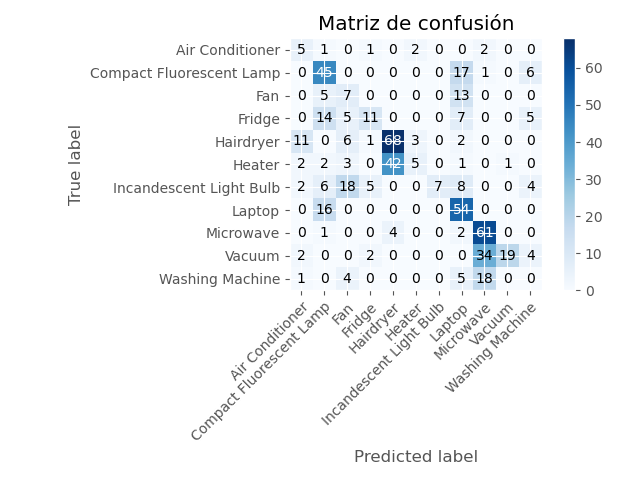

In [106]:
# EXPERIMENTAR

ids_EDMIIE = get_ids(PLAID=False)
ids_EDMIIE_otros = get_ids_por_tipo(11, PLAID=False)-np.full_like(get_ids_por_tipo(11, PLAID=False), 1)
ids_EDMIIE_sin_otros = np.reshape(np.delete(ids_EDMIIE, ids_EDMIIE_otros), (-1,1))

accuracies_EDMIIE_sobre_PLAID = np.empty(len(ids_EDMIIE_sin_otros))
predictions_EDMIIE_sobre_PLAID = np.empty(len(ids_EDMIIE_sin_otros))

TIPO_EDMIIE_sin_otros = np.delete(TIPO_EDMIIE, ids_EDMIIE_otros)
CASA_EDMIIE_sin_otros = np.delete(CASA_EDMIIE, ids_EDMIIE_otros)
caracteristicas_EDMIIE_sin_otros = np.empty((len(ids_EDMIIE_sin_otros),272))

k = 0
for x in ids_EDMIIE_sin_otros:
    k_test = caracteristicas_EDMIIE[x[0]-1,:].reshape(1, -1)
    caracteristicas_EDMIIE_sin_otros[k] = caracteristicas_EDMIIE[x[0]-1,:]
    k_pred = clf_PLAID.predict(k_test)
    k_tipo = []
    k_tipo.append(get_tipo(x-1, False))
    k_acc = clf_PLAID.score(k_test, k_tipo)
    
    accuracies_EDMIIE_sobre_PLAID[k] = k_acc
    predictions_EDMIIE_sobre_PLAID[k] = k_pred
    
    k += 1

    
mostrar_performance(accuracies_EDMIIE_sobre_PLAID, predictions_EDMIIE_sobre_PLAID, TIPO_EDMIIE_sin_otros)                            
    

## Parte 4. Clasificación. Entrenamiento y validación cruzada sobre base EDM-IIE

En este caso se usará la base completa EDM-IIE para entrenar un clasificador con el mismo esquema de la práctica 4.

## 4.1 Calcular las características

In [33]:
# COMPLETAR

TIPO_EDMIIE, CASA_EDMIIE, DATOS_IEEE_EDMIIE, factores_EDMIIE, IMG_VI_EDMIIE, caracteristicas_EDMIIE = calcular_caracteristicas_EDMIIE()

## 4.2 Entrenamiento y validación cruzada

Clasificador: RF(n=100), Características: Todas
Acierto medio = 59.52
Confusion matrix, without normalization
[[ 5  0  0  2  1  1  0  0  1  1  0]
 [ 0 57  0  3  2  0  2  2  3  0  0]
 [ 0  7  0  6  2  0  7  0  1  0  2]
 [ 0 10  2 17  5  3  0  0  2  1  2]
 [ 0  0  1  6 52 26  0  0  6  0  0]
 [ 0  1  1  0 35 15  0  0  4  0  0]
 [ 0  5  3  2 10  0 28  2  0  0  0]
 [ 0 11  0  1  0  0  0 58  0  0  0]
 [ 0  2  0  1  0  4  0  0 60  1  0]
 [ 0  0  0  3  1  0  0  0  0 37 20]
 [ 0  2  2  2  1  0  0  0  6  5 10]]


<IPython.core.display.Javascript object>


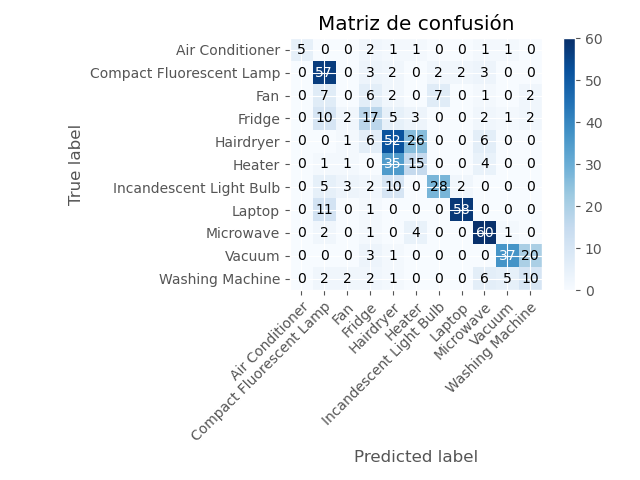

In [144]:
# COMPLETAR

clasificador_EDMIIE = RF(n_estimators=100)

accuracies_EDMIIE, y_predictions_EDMIIE, clf_EDMIIE = clasificar(clasificador_EDMIIE, caracteristicas_EDMIIE_sin_otros, TIPO_EDMIIE_sin_otros, CASA_EDMIIE_sin_otros)

print('Clasificador: RF(n=100), Características: Todas')

mostrar_performance(accuracies_EDMIIE, y_predictions_EDMIIE, TIPO_EDMIIE_sin_otros)

## Parte 5. Funcionamiento en línea punta a punta

En esta parte se debe implementar una función que adquiera una señal y la clasifique con los clasficadores implementados en la partes 2 y/o 4.  

Cada vez que se ejecuta se debe mostrar las señales adquiridas y la clasificación dada por el clasificador. La clasificación se puede mostrar como la predicción dada por el clasificador pero puede ser interesante también mostrar las probabilidades asignadas a cada tipo de electrodoméstico. Para mostrar las probabilidades puede ser útil usar una gráfica de barras horizontales **plt.barh**. 






### 5.1 Adquirir y clasificar

#### Para usar esta función, setear antes los parámetros Ki y Kv en las casillas correspondientes al principio del Notebook.

In [155]:
cf = clf_EDMIIE  #clasificador a utilizar 

button_adquirir_clasificar = widgets.Button(description="Adquirir y clasificar")
output_adquirir_clasificar = widgets.Output()


def adquirir_y_clasificar(clasificador, cantidad_de_muestras, ciclos_a_saltear, ciclos_a_cargar):
    # COMPLETAR
    # Completar el código de la función
    
    adquirir()
    I,V = cargar_VI_por_ciclos('./TMP_MUESTRAS_ADQUIRIDAS_ESCALADAS.csv', frecuencia_muestreo=25000, frecuencia_linea=50)
    
    DATOS_IEEE = np.empty((1, 14))
    S, S_11, S_H, S_N, P, P_11, P_H, Q_11, D_I, D_V, D_H, N, THD_V, THD_I = calcular_potencia_IEEE_1459_2010(I,V, frecuencia_muestreo=25000, frecuencia_linea=50)
    DATOS_IEEE[0,0] = S
    DATOS_IEEE[0,1] = S_11
    DATOS_IEEE[0,2] = S_H
    DATOS_IEEE[0,3] = S_N
    DATOS_IEEE[0,4] = P
    DATOS_IEEE[0,5] = P_11
    DATOS_IEEE[0,6] = P_H
    DATOS_IEEE[0,7] = Q_11
    DATOS_IEEE[0,8] = D_I
    DATOS_IEEE[0,9] = D_V
    DATOS_IEEE[0,10] = D_H
    DATOS_IEEE[0,11] = N
    DATOS_IEEE[0,12] = THD_V
    DATOS_IEEE[0,13] = THD_I
    
    FP_fun = np.array([P_11 / S_11]) # FP_fun = P_11/S_11
    FP_tot = np.array([P / S]) # FP_tot = P/S
    
    IMG_VI = np.array([np.ravel(get_img_from_VI(V,I, width=16, hard_threshold=True))])
    
    factores = np.transpose(np.vstack((FP_fun, FP_tot)))
    todas_juntas = np.hstack((factores, DATOS_IEEE))
    caracteristicas = np.hstack((todas_juntas, IMG_VI))
    
    
    k_test = caracteristicas
    k_pred = clasificador.predict(k_test)
    k_pred_proba = clasificador.predict_proba(k_test)
    
    print()
    print("El electrodoméstico es probablemente de tipo: ", nombres_electrodomesticos[k_pred[0]])
    plt.figure()
    plt.title("Probabilidad por tipo")
    plt.barh(['AirC','CFL','Fan','Frid','Hair','Heat','ILB','Lapt','MWave','Vacc','Wash'], k_pred_proba[0])
    plt.show()
    
    return k_pred_proba[0], k_pred
    
    
def on_button_adquirir_clasificar_clicked(b):
    output_adquirir_clasificar.clear_output()
    with output_adquirir_clasificar:
        adquirir_y_clasificar(clasificador = cf, cantidad_de_muestras=25000*2, ciclos_a_saltear=50, ciclos_a_cargar=20)
       
button_adquirir_clasificar.on_click(on_button_adquirir_clasificar_clicked)
display(button_adquirir_clasificar, output_adquirir_clasificar)


Button(description='Adquirir y clasificar', style=ButtonStyle())

Output()